<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_CS_Net_Fully_Connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-00jw1lq1
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-00jw1lq1
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7333 sha256=f5503465380a6e58333bf869546ba26fef0705450e6ff8929373198fdc43d997
  Stored in directory: /tmp/pip-ephem-wheel-cache-iw5qqu89/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.utils

In [ ]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [ ]:
latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 32

In [ ]:
#MNIST
train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
#train_set = datasets.KMNIST('./data', train=True, download=True)
#test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
# train_set = datasets.FashionMNIST('./data', train=True, download=True)
# test_set = datasets.FashionMNIST('./data', train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [ ]:
X.shape,Y.shape,X_test.shape,Y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

In [ ]:
###################################################

In [ ]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [ ]:
X = GPU_data(X)
X_test = GPU_data(X_test)

Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

In [ ]:
X = (X + 1)/2
X_test = (X_test + 1)/2

In [ ]:
def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:,:]
        y = Y_test[r:r+b]
    return x,y

In [ ]:
x,y = get_batch('train')

(array([21145.,   300.,   241.,   220.,   240.,   256.,   261.,   260.,
          336.,  1829.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

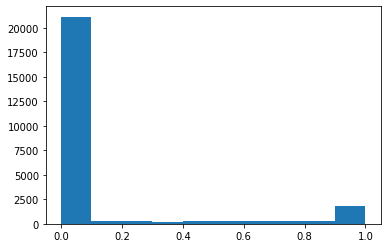

In [ ]:
plt.hist(x.flatten().cpu().numpy())

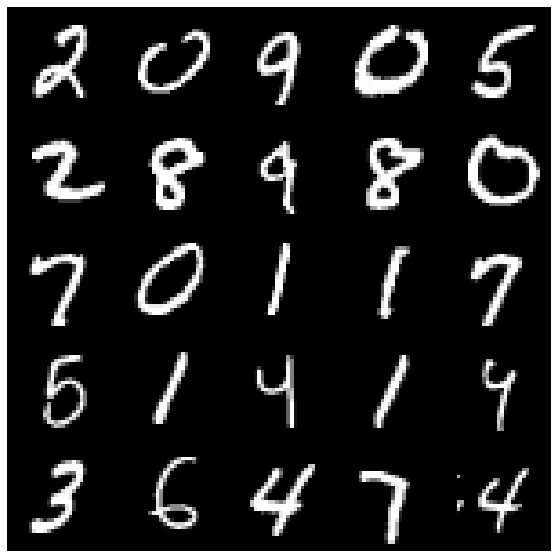

In [ ]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy())

In [ ]:
X = X.view(-1,784)
X_test = X_test.view(-1,784)

def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [ ]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [ ]:
def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  

In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [ ]:
def gradient_step(w):

    for j in range(len(w)): 

            w[j].data = w[j].data - c.h*w[j].grad.data
            
            w[j].grad.data.zero_()

In [ ]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.9) 
# scheduler.step(acc_best)

In [ ]:
def make_plots():
    
    acc_train = acc(model(x,w),y)
    
    # xt,yt = get_batch('test')
    # acc_test = acc(model(xt,w),yt)

    acc_test = acc(model(X_test,w),Y_test)

    if acc_test > acc_best:

        acc_best = acc_test
        w_best = w

    wb.log({"acc_train": acc_train, "acc_test": acc_test, "acc_best": acc_best})

In [ ]:
def relu(x):
    return x * (x > 0)

In [ ]:
def model(x,w):

    for j in range(len(w)):
        
        x = relu(matmul(x,w[j]))

    return x

In [ ]:
def Exp1(mode):

    def get_batch(mode):
        b = 4096
        if mode == "train":
            r = np.random.randint(X.shape[0]-b) 
            x = X[r:r+b,:]
            y = Y[r:r+b]
        elif mode == "test":
            r = np.random.randint(X_test.shape[0]-b)
            x = X_test[r:r+b,:]
            y = Y_test[r:r+b]
        return x,y

    def make_plots(acc_best):
        acc_train = acc(model(x,w),y)
        xt,yt = get_batch('test')
        acc_test = acc(model(xt,w),yt)
        if acc_test > acc_best:
            acc_best = acc_test
            w_best = w
        wb.log({"acc_train": acc_train, "acc_test": acc_test, "acc_best": acc_best})
        return acc_best

    X = train_set.data.numpy()
    X_test = test_set.data.numpy()
    Y = train_set.targets.numpy()
    Y_test = test_set.targets.numpy()
    X = X[:,None,:,:]/255
    X_test = X_test[:,None,:,:]/255
    X = (X - 0.5)/0.5
    X_test = (X_test - 0.5)/0.5
    X = GPU_data(X)
    X_test = GPU_data(X_test)
    Y = GPU_data(Y)
    Y_test = GPU_data(Y_test)
    X = (X + 1)/2
    X_test = (X_test + 1)/2
    X = X.view(-1,784)
    X_test = X_test.view(-1,784)
    ##################################################
    wb.init(project="Simple Fully Connected MNIST CS 11");
    c = wb.config

    c.h = 0.001
    c.b = 2**13
    c.layers = 2 
    c.epochs = 100
    c.steps = 1000

    c.CS = mode #(np.random.random() < 0.5) == 0 #Coin flip

    if c.CS:
        print("CS Version")
        N = X.shape[1]
        M = N//10;  #Samples
        D = GPU_data(torch.randn(N,M))
        X = torch.matmul(X,D)
        X_test = torch.matmul(X_test,D)
    else:
        print("Regular Version")
        M = 784

    c.m = M

    c.f_n = [M,1024,128,10]

    w      = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]
    w_best = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

    acc_best = 0.1

    optimizer = torch.optim.Adam(w, lr=c.h) 


    for i in range(c.epochs):

        for j in range(c.steps):

            x,y = get_batch('train')

            loss = cross_entropy(softmax(model(x,w)),y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        acc_best = make_plots(acc_best)

In [ ]:
CS = True
Regular = False

In [ ]:
for i in range(10):
    Exp1(CS)
    Exp1(Regular)

acc_train,0.19653
acc_test,0.19067
acc_best,0.20068
_step,16
_runtime,55
_timestamp,1611817637


acc_train,▆▁▃▇▄▆▅▄▇▆█▅▃▄▅▃▄
acc_test,▅▇▂▃▂▂▃▂█▄▁▇▄▄▅▃▁
acc_best,▁▅▅▅▅▅▅▅█████████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
_runtime,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


CS Version


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


acc_train,0.99731
acc_test,0.97314
acc_best,0.98706
_step,99
_runtime,291
_timestamp,1611817939


acc_train,▁▁▃▇████████████████████████████████████
acc_test,▁▁▂▇████████████████████████████████████
acc_best,▁▁▂▇████████████████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Regular Version


In [ ]:
# wb.init(project="Simple Fully Connected MNIST");
# c = wb.config

# c.h = 0.001
# c.b = 100
# c.layers = 2 
# c.epochs = 100000

# c.f_n = [784,500,10]

# w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

# for i in range(c.epochs):

#     x,y = get_batch('train')

#     loss = cross_entropy(softmax(model(x,w)),y)

#     loss.backward()

#     gradient_step(w)
   
#     if (i+1) % 1 == 0:

#         make_plots()

In [ ]:
####With Adam Optimizer

In [ ]:
# wb.init(project="Simple Fully Connected MNIST");
# c = wb.config

# c.h = 0.001
# c.b = 100
# c.layers = 2 
# c.epochs = 100000

# c.f_n = [784,500,10]

# w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

# optimizer = torch.optim.Adam(w, lr=c.h)  

# for i in range(c.epochs):

#     x,y = get_batch('train')

#     loss = cross_entropy(softmax(model(x,w)),y)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
   
#     if (i+1) % 1 == 0:

#         make_plots()

In [ ]:
# acc(model(X,w),Y)

In [ ]:
# acc(model(X_test,w),Y_test)

In [ ]:
# model(X[0],w)

In [ ]:
# torch.argmax(model(X[0],w))

In [ ]:
# Y[0]

In [ ]:
# # for i in range(len(w)):

#     plt.imshow(w[i].cpu().detach().numpy())
#     plt.show()

In [ ]:
#CS Version

In [ ]:
# X.shape

In [ ]:
# N = X.shape[1]
# M = N//10;  #Samples

# D = GPU_data(torch.randn(N,M))

In [ ]:
# D.shape

In [ ]:
# X = torch.matmul(X,D)
# X_test = torch.matmul(X_test,D)

In [ ]:
# X.shape

In [ ]:
# wb.init(project="Simple Fully Connected MNIST CS");
# c = wb.config

# c.h = 0.0001
# c.b = 100
# c.layers = 2 
# c.epochs = 1000000

# c.f_n = [M,500,500,10]

# w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

# optimizer = torch.optim.Adam(w, lr=c.h)  

# for i in range(c.epochs):

#     x,y = get_batch('train')

#     loss = cross_entropy(softmax(model(x,w)),y)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
   
#     if (i+1) % 1 == 0:

#         make_plots()

In [ ]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5
X = GPU_data(X)
X_test = GPU_data(X_test)
Y = GPU_data(Y)
Y_test = GPU_data(Y_test)
X = (X + 1)/2
X_test = (X_test + 1)/2
X = X.view(-1,784)
X_test = X_test.view(-1,784)
##################################################
wb.init(project="Simple Fully Connected MNIST CS 2");
c = wb.config

c.h = 0.001
c.b = 4096
c.layers = 2 
c.epochs = 28000
M = 784

c.CS = True
if c.CS:
    N = X.shape[1]
    M = N//10;  #Samples
    D = GPU_data(torch.randn(N,M))
    X = torch.matmul(X,D)
    X_test = torch.matmul(X_test,D)

c.m = M

c.f_n = [M,128,128,10]

w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

optimizer = torch.optim.Adam(w, lr=c.h)  

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    make_plots()

acc_train,0.5
acc_test,0.34375
_step,18859
_runtime,82
_timestamp,1611720652


acc_train,▁▁▂▃▄▃▅▇▅▅▆█▆▅▅█▄▆▆▅▇▅▇▇▆▆▅▆▇▇▆▇▇▆▇▆▅██▆
acc_test,▁▁▂▃▃▄▄▅▅▇▆▆▇▆▆▅▅▆▅▅▆▆▅▆▄▇▇▇█▇▆▆▅▆▆▇▆█▇▅
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
